In [1]:
import pandas as pd
from Func_extr import *
from Func_viz import *
from Func_analisis  import *         

In [2]:
pixel = 195

mapRep_coper(pixel)

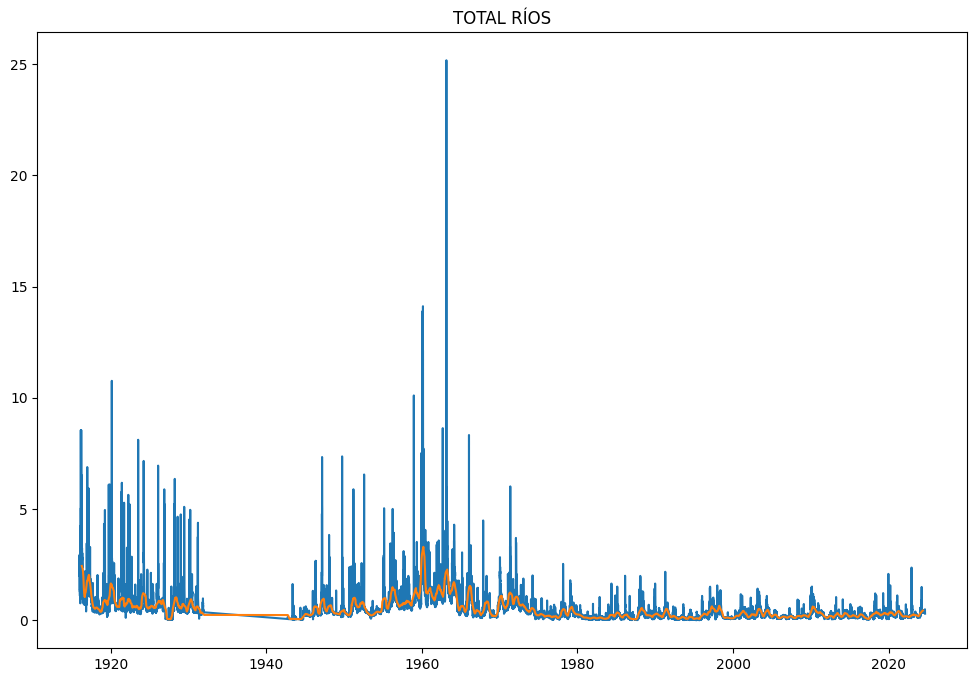

In [3]:
hist_evAgua (pixel, soloAgregados = True)

In [4]:
df_embalses, df_rios, df_c, df_aemet = dataExtract(pixel, x = True)

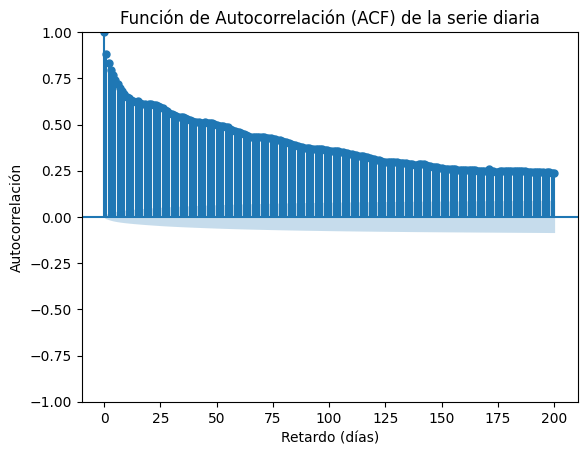

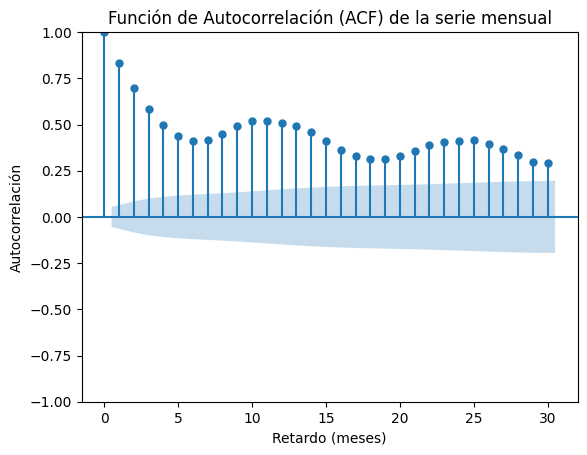

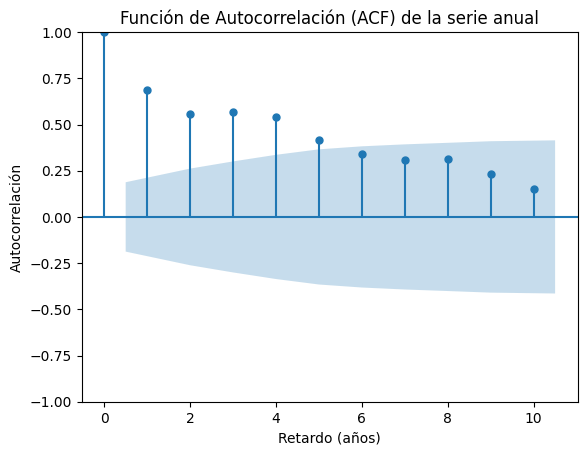

In [5]:
df_rios = df_rios.groupby('date').mean().reset_index()
autocorr_serie (df_rios, ['quantity_hm3'], lags_list = [200,30,10])

In [338]:
df = create_df(pixel)
##Retardos tiempo natural
variables = ['total_precipitation','evaporation','skin_temperature']
df = retardAvg_tNat(df, vars = variables, lags = [1,7,15,20], frec = 'D')
df = retardAvg_tNat(df, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
df = retardAvg_tNat(df, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
df = retardAgg_tNat(df, vars = variables, lags = [1,7,15,20], frec = 'D')
df = retardAgg_tNat(df, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
df = retardAgg_tNat(df, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
#retardos tiempo dinámico
df = df.sort_values('date').set_index('date')
#df = retardAvg_tDin(df, vars = ['total_precipitation','evaporation','tmed','prec'], lags = [1,7,15,20,30,60,100,200,365,730])
#df = retardAgg_tDin(df, vars = ['total_precipitation','evaporation','tmed','prec'], lags = [1,7,15,20,30,60,100,200,365,730])
df = df.select_dtypes(exclude=['datetime64'])
correlaciones = df.corr()
quantity_hm3_corr = correlaciones['quantity_hm3'].reset_index()
masCorreladasAgua = quantity_hm3_corr[abs(quantity_hm3_corr['quantity_hm3']) >0.1]['index'].to_list()
print(quantity_hm3_corr[(quantity_hm3_corr['quantity_hm3']) >0.2].sort_values('quantity_hm3', ascending = False) )
print(quantity_hm3_corr[(quantity_hm3_corr['quantity_hm3']) <-0.2].sort_values('quantity_hm3', ascending = True) )

                               index  quantity_hm3
8                       quantity_hm3      1.000000
7                         soil_water      0.416303
25   total_precipitation_mean_last6M      0.331962
70    total_precipitation_sum_last6M      0.331254
42   total_precipitation_mean_last4Y      0.324147
87    total_precipitation_sum_last4Y      0.321803
41   total_precipitation_mean_last3Y      0.319717
86    total_precipitation_sum_last3Y      0.316344
24   total_precipitation_mean_last4M      0.314191
69    total_precipitation_sum_last4M      0.312550
40   total_precipitation_mean_last2Y      0.308761
26   total_precipitation_mean_last8M      0.304842
71    total_precipitation_sum_last8M      0.304644
85    total_precipitation_sum_last2Y      0.303870
43   total_precipitation_mean_last5Y      0.296740
88    total_precipitation_sum_last5Y      0.294679
23   total_precipitation_mean_last3M      0.286218
68    total_precipitation_sum_last3M      0.283810
39   total_precipitation_mean_l

### PCA

In [339]:
pca_df = process_pca_for_variables(df = df, variables = variables, frecuencias = ['D', 'M', 'Y'], var_threshold=90)

In [340]:
df_PCA_quant = pd.merge(df.reset_index()[['date', 'quantity_hm3']],pca_df, on = 'date', how = 'inner').set_index('date')

In [345]:
df_PCA_quant.corr()['quantity_hm3']


quantity_hm3                       1.000000
total_precipitation_PCA_D_comp1    0.230218
total_precipitation_PCA_D_comp2   -0.053094
total_precipitation_PCA_M_comp1    0.211080
total_precipitation_PCA_M_comp2    0.088689
total_precipitation_PCA_M_comp3    0.027754
total_precipitation_PCA_Y_comp1    0.217747
total_precipitation_PCA_Y_comp2    0.408626
total_precipitation_PCA_Y_comp3   -0.024386
evaporation_PCA_D_comp1            0.143195
evaporation_PCA_M_comp1            0.055593
evaporation_PCA_M_comp2            0.139822
evaporation_PCA_Y_comp1            0.077669
evaporation_PCA_Y_comp2            0.492486
evaporation_PCA_Y_comp3            0.075787
skin_temperature_PCA_D_comp1       0.134955
skin_temperature_PCA_D_comp2       0.043364
skin_temperature_PCA_M_comp1       0.471250
skin_temperature_PCA_M_comp2       0.163511
skin_temperature_PCA_M_comp3      -0.021178
skin_temperature_PCA_M_comp4       0.143918
skin_temperature_PCA_Y_comp1       0.513661
skin_temperature_PCA_Y_comp2    

### Predicciones

#### Regresion lineal

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = df_PCA_quant.drop(['quantity_hm3'], axis=1)  # Excluir 'date' si no se usa explícitamente
y = df_PCA_quant['quantity_hm3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de Regresión Lineal
linear_model = LinearRegression()

# Entrenar el modelo
linear_model.fit(X_train, y_train)

# Predicciones
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Métricas de evaluación
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"R^2 en entrenamiento: {train_r2:.4f}")
print(f"R^2 en test: {test_r2:.4f}")
print(f"RMSE en entrenamiento: {train_rmse:.4f}")
print(f"RMSE en test: {test_rmse:.4f}")

R^2 en entrenamiento: 0.5472
R^2 en test: 0.5617
RMSE en entrenamiento: 0.3861
RMSE en test: 0.3729


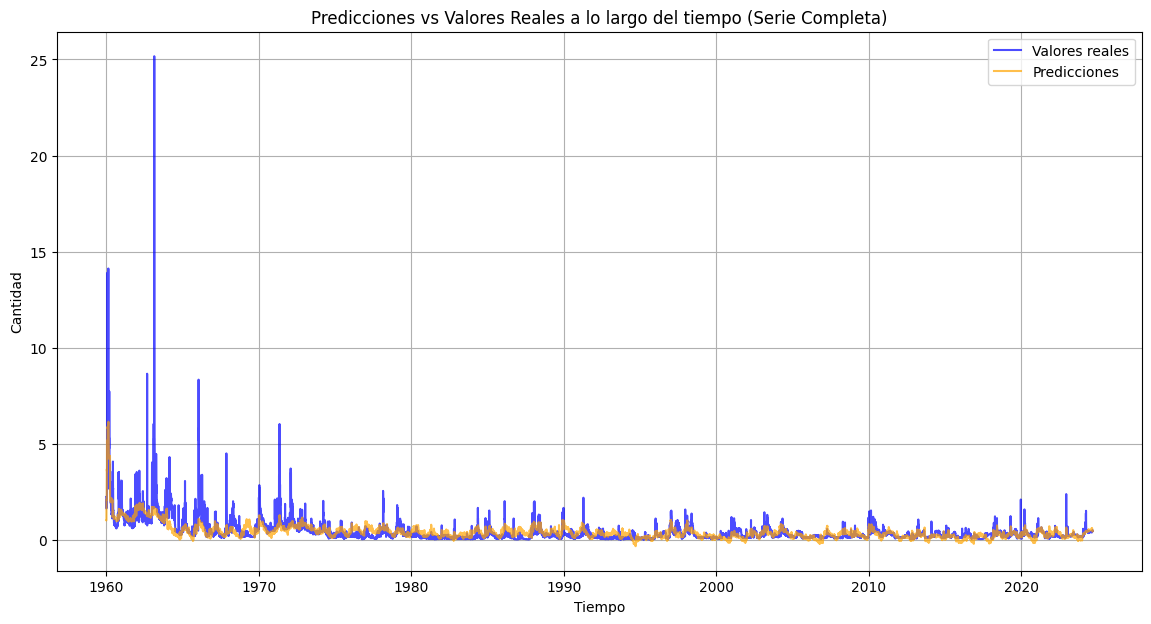

In [13]:
# Concatenar datos de entrenamiento y prueba
y_all = pd.concat([y_train, y_test])
y_pred_all = pd.concat([pd.Series(y_train_pred, index=y_train.index), pd.Series(y_test_pred, index=y_test.index)])

# Asegurarnos de que estén ordenados por tiempo
y_all = y_all.sort_index()
y_pred_all = y_pred_all.sort_index()

# Graficar
plt.figure(figsize=(14, 7))
plt.plot(y_all.index, y_all, label='Valores reales', color='blue', alpha=0.7)
plt.plot(y_pred_all.index, y_pred_all, label='Predicciones', color='orange', alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad')
plt.title('Predicciones vs Valores Reales a lo largo del tiempo (Serie Completa)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
X = df_PCA_quant.drop('quantity_hm3', axis=1)
y = df_PCA_quant['quantity_hm3']

# Añadir una constante para el término independiente (intercepto)
X = sm.add_constant(X)

# Ajustar el modelo usando Statsmodels
model = sm.OLS(y, X)  # Ordinary Least Squares
results = model.fit()

# Mostrar el resumen del modelo
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           quantity_hm3   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     1201.
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:05:38   Log-Likelihood:                -10861.
No. Observations:               23594   AIC:                         2.177e+04
Df Residuals:                   23569   BIC:                         2.197e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

#### Random Forests

In [341]:
df_PCA_quant = pd.merge(df.reset_index()[['date', 'quantity_hm3']],pca_df, on = 'date', how = 'inner').set_index('date')
X = df_PCA_quant.drop(['quantity_hm3'], axis=1)  # Excluir 'date' si no se usa explícitamente
y = df_PCA_quant['quantity_hm3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modelo de Random Forest
rf_agua = RandomForestRegressor(
    n_estimators=40,          # Cantida de árboles para capturar patrones
    max_depth=20,            # Límite de profundidad
    min_samples_split=20,       # Divisiones 
    min_samples_leaf=15,        # Permite hojas pequeñas
    random_state=42,           # Reproducibilidad
    bootstrap=True            # 
)

# Entrenar en todos los datos
rf_agua.fit(X_train, y_train)

# Predicciones
y_train_pred = rf_agua.predict(X_train)
y_test_pred = rf_agua.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"R^2 en entrenamiento: {train_r2:.4f}")
print(f"R^2 en test: {test_r2:.4f}")




# Importancia de las características
#feature_importances = pd.DataFrame({
 #   'Feature': X.columns,
  #  'Importance': rf.feature_importances_
#}).sort_values(by='Importance', ascending=False)

R^2 en entrenamiento: 0.8310
R^2 en test: 0.8366


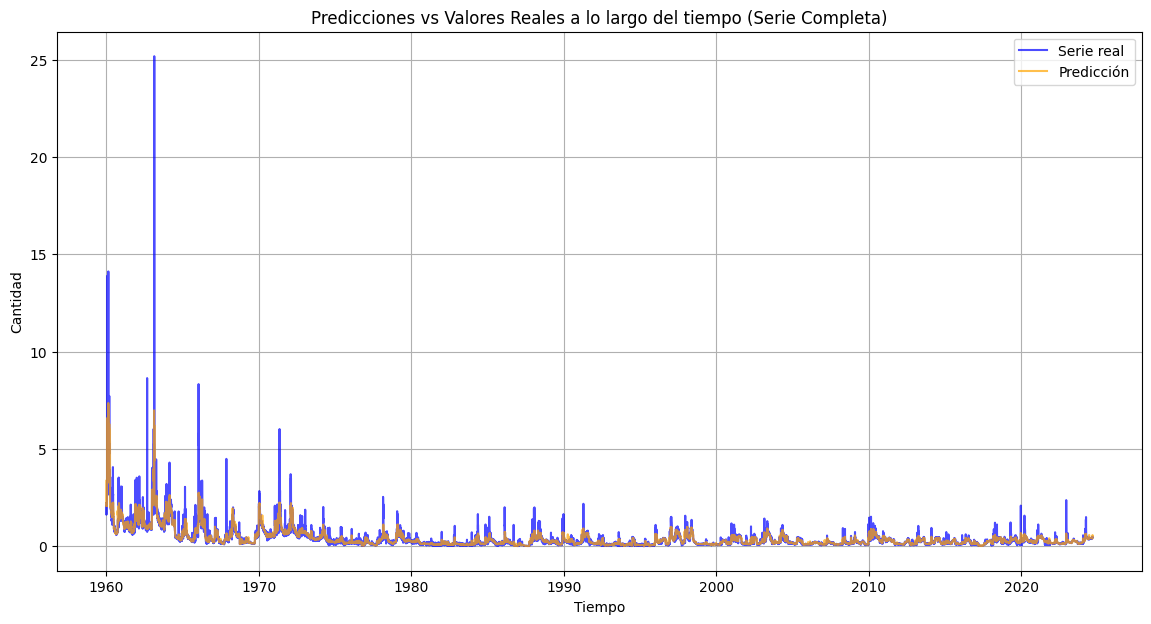

In [26]:
y_predict_train = pd.Series(y_train_pred)
y_predict_test = pd.Series(y_test_pred)

y_predict = pd.concat([y_predict_train, y_predict_test])
y_predict = y_predict.reset_index()[0]
y = pd.concat([y_train, y_test]).reset_index()
x = pd.concat([X_train, X_test])
df_merge = pd.merge(y,x, on ='date')

df_merge['quantity_hm3_predict'] = y_predict
df_merge.sort_values('date',inplace = True)
df_merge.set_index('date', inplace = True)
plt.figure(figsize=(14, 7))
plt.plot(df_merge['quantity_hm3'], label = 'Serie real', color='blue', alpha=0.7 )
plt.plot(df_merge['quantity_hm3_predict'] , label = 'Predicción', color='orange', alpha=0.7)
plt.title('Predicciones vs Valores Reales a lo largo del tiempo (Serie Completa)')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad')
plt.grid(True)
plt.legend()
plt.show()

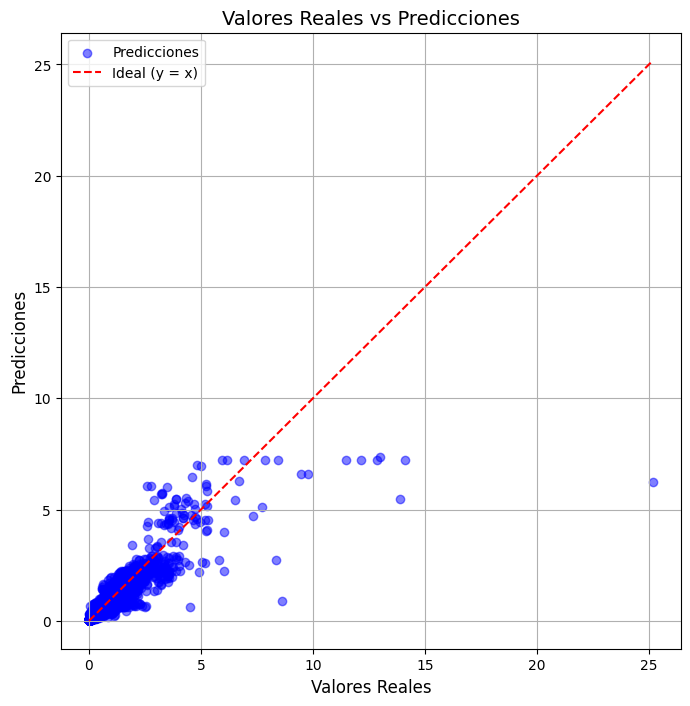

In [45]:
# Crear la gráfica de dispersión
plt.figure(figsize=(8, 8))
plt.scatter(df_merge['quantity_hm3'], df_merge['quantity_hm3_predict'], alpha=0.5, color='blue', label='Predicciones')
plt.plot([min(df_merge['quantity_hm3']), max(df_merge['quantity_hm3'])], [min(df_merge['quantity_hm3']), max(df_merge['quantity_hm3'])], color='red', linestyle='--', label='Ideal (y = x)')

# Etiquetas y título
plt.xlabel('Valores Reales', fontsize=12)
plt.ylabel('Predicciones', fontsize=12)
plt.title('Valores Reales vs Predicciones', fontsize=14)
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [41]:
feature_importances[feature_importances['Importance']>0.01]

,Feature,Importance
20,skin_temperature_PCA_Y_comp1,0.212531
12,evaporation_PCA_Y_comp2,0.160435
9,evaporation_PCA_M_comp1,0.148934
11,evaporation_PCA_Y_comp1,0.081912
2,total_precipitation_PCA_M_comp1,0.051924
14,skin_temperature_PCA_D_comp1,0.050606
0,total_precipitation_PCA_D_comp1,0.048769
16,skin_temperature_PCA_M_comp1,0.046106
19,skin_temperature_PCA_M_comp4,0.030369
3,total_precipitation_PCA_M_comp2,0.027894


#### Proyecciones futuras

In [235]:
def modelo_caracteristicas (pixel, var_output):
    df = create_df(pixel)
    ##Retardos tiempo natural
    variables =  ['total_precipitation','evaporation','skin_temperature','soil_water','runoff','high_vegetation_cover','low_vegetation_cover']
    variables.remove(var_output)
    df = retardAvg_tNat(df, vars = variables, lags = [1,7,15,20], frec = 'D')
    df = retardAvg_tNat(df, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
    df = retardAvg_tNat(df, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
    df = retardAgg_tNat(df, vars = variables, lags = [1,7,15,20], frec = 'D')
    df = retardAgg_tNat(df, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
    df = retardAgg_tNat(df, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
    df = df.sort_values('date').set_index('date')
    df = df.select_dtypes(exclude=['datetime64'])
    
    df_retardos= df[[i for i in df.columns if 'Y' in i or 'M' in i or 'D' in i]].dropna().select_dtypes(exclude=['datetime64'])
    pca_df = process_pca_for_variables(df = df, variables = variables, frecuencias = ['Y'], var_threshold=90)
    pca_df = process_pca_for_variables(df = df, variables = variables, frecuencias = ['M'], var_threshold=90)
    pca_df = process_pca_for_variables(df = df, variables = variables, frecuencias = ['D'], var_threshold=90)
    df_PCA_quant = pd.merge(df.reset_index()[['date', var_output]],pca_df, on = 'date', how = 'inner').set_index('date')
    
    X = df_PCA_quant.drop([var_output], axis=1)  # Excluir 'date' si no se usa explícitamente
    y = df_PCA_quant[var_output]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    # Modelo de Random Forest
    rf = RandomForestRegressor(
        n_estimators=40,          # Cantida de árboles para capturar patrones
        max_depth=20,            # Límite de profundidad
        min_samples_split=20,       # Divisiones 
        min_samples_leaf=15,        # Permite hojas pequeñas
        random_state=42,           # Reproducibilidad
        bootstrap=True            # 
    )
    
    
    # Entrenar en todos los datos
    rf.fit(X_train, y_train)
    
    # Predicciones
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"R^2 en entrenamiento: {train_r2:.4f}")
    print(f"R^2 en test: {test_r2:.4f}")
    return rf

In [236]:
rf_prec = modelo_caracteristicas (pixel, 'total_precipitation' ) 
rf_ev = modelo_caracteristicas (pixel, 'evaporation' ) 
rf_temp = modelo_caracteristicas (pixel, 'skin_temperature' ) 
rf_sw = modelo_caracteristicas (pixel, 'soil_water' ) 
rf_rff = modelo_caracteristicas (pixel, 'runoff' ) 
rf_hv = modelo_caracteristicas (pixel, 'high_vegetation_cover' ) 
rf_lv = modelo_caracteristicas (pixel, 'low_vegetation_cover' ) 

PCA aplicado para variable 'evaporation' y frecuencia 'Y'.
Varianza explicada acumulada para los 3 componentes: 94.7181511546304%
PCA aplicado para variable 'skin_temperature' y frecuencia 'Y'.
Varianza explicada acumulada para los 4 componentes: 93.47849074587867%
PCA aplicado para variable 'soil_water' y frecuencia 'Y'.
Varianza explicada acumulada para los 3 componentes: 93.61080368030944%
PCA aplicado para variable 'runoff' y frecuencia 'Y'.
Varianza explicada acumulada para los 2 componentes: 94.46351670368122%
PCA aplicado para variable 'high_vegetation_cover' y frecuencia 'Y'.
Varianza explicada acumulada para los 3 componentes: 93.28142775662799%
PCA aplicado para variable 'low_vegetation_cover' y frecuencia 'Y'.
Varianza explicada acumulada para los 4 componentes: 93.29644562668359%
PCA aplicado para variable 'evaporation' y frecuencia 'M'.
Varianza explicada acumulada para los 2 componentes: 96.55676940827031%
PCA aplicado para variable 'skin_temperature' y frecuencia 'M'.
Va

In [334]:
def pca_var(df,var_output, variables):
    #variables =  ['total_precipitation','evaporation','skin_temperature','soil_water','runoff','high_vegetation_cover','low_vegetation_cover']
    variables.remove(var_output)
    df = retardAvg_tNat(df, vars = variables, lags = [1,7,15,20], frec = 'D')
    df = retardAvg_tNat(df, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
    df = retardAvg_tNat(df, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
    df = retardAgg_tNat(df, vars = variables, lags = [1,7,15,20], frec = 'D')
    df = retardAgg_tNat(df, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
    df = retardAgg_tNat(df, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
    df = df.sort_values('date').set_index('date')
    df = df.select_dtypes(exclude=['datetime64'])
    
    df_retardos= df[[i for i in df.columns if 'Y' in i or 'M' in i or 'D' in i]].dropna().select_dtypes(exclude=['datetime64'])
    df_retardos = process_pca_for_variables(df = df_retardos, variables = variables, frecuencias = ['Y'], var_threshold=90)
    df_retardos = process_pca_for_variables(df = df_retardos, variables = variables, frecuencias = ['M'], var_threshold=90)
    df_retardos = process_pca_for_variables(df = df_retardos, variables = variables, frecuencias = ['D'], var_threshold=90)
    df_PCA_quant = pd.merge(df.reset_index()[['date', var_output]],pca_df, on = 'date', how = 'inner').set_index('date')
    
    X = df_PCA_quant.drop([var_output], axis=1)  # Excluir 'date' si no se usa explícitamente
    return X

In [336]:
from datetime import datetime, timedelta


start_date = datetime(2024, 9, 6)
end_date = datetime(2030, 9, 5)
df_new_day = create_df(pixel).reset_index().drop('snowfall', axis = 1)
df_new_day.sort_values('date')

vars = ['total_precipitation','evaporation',  'skin_temperature', 'soil_water', 'runoff', 'high_vegetation_cover', 'low_vegetation_cover']

dict_var_models = {'total_precipitation' : rf_prec, 'evaporation' : rf_ev,  'skin_temperature' : rf_temp, 'soil_water' : rf_sw, 'runoff' : rf_rff, 'high_vegetation_cover' : rf_hv, 'low_vegetation_cover' : rf_lv, 'quantity_hm3' : rf_agua}
current_date = start_date
predicciones_Totales = {}
while current_date <= end_date:
    print(current_date)
    # Crear el DataFrame para el nuevo día
    prediccionesSiguienteDia = {}
    for var in vars:
        df_var = pca_var(df = df_new_day, var_output = var, variables = ['total_precipitation','evaporation','skin_temperature','soil_water','runoff','high_vegetation_cover','low_vegetation_cover'])
        
        # Selecciona solo la última fila para predecir el siguiente día
        df_var_last = df_var.iloc[[-1]]  # Esto selecciona la última fila
        
        # Realiza la predicción solo para esa fila
        prediccion = dict_var_models[var].predict(df_var_last)
        
        # Guarda la predicción (solo un valor)
        prediccionesSiguienteDia[var] = prediccion[0]
    ##quantity:
    df_quant = pca_var(df = df_new_day, var_output = 'quantity_hm3', variables =  ['total_precipitation','evaporation','skin_temperature','quantity_hm3'])
    df_quantity_hm3_last = df_quant.iloc[[-1]]
    prediccion = dict_var_models['quantity_hm3'].predict(df_quantity_hm3_last)
    prediccionesSiguienteDia['quantity_hm3'] = prediccion[0]
    
    predicciones_Totales[current_date] = prediccionesSiguienteDia
    predicciones_Totales_df = pd.DataFrame(predicciones_Totales).T.reset_index().rename(columns ={ 'index' : 'date'})
    
    df_new_day = pd.concat([df_new_day, pd.DataFrame([predicciones_Totales_df])])
    
    current_date += timedelta(days=1)
    

2024-09-06 00:00:00
No hay columnas para aplicar PCA con frecuencia M para la variable 'evaporation'.
No hay columnas para aplicar PCA con frecuencia M para la variable 'skin_temperature'.
No hay columnas para aplicar PCA con frecuencia M para la variable 'soil_water'.
No hay columnas para aplicar PCA con frecuencia M para la variable 'runoff'.
No hay columnas para aplicar PCA con frecuencia M para la variable 'high_vegetation_cover'.
No hay columnas para aplicar PCA con frecuencia M para la variable 'low_vegetation_cover'.
No hay columnas para aplicar PCA con frecuencia D para la variable 'evaporation'.
No hay columnas para aplicar PCA con frecuencia D para la variable 'skin_temperature'.
No hay columnas para aplicar PCA con frecuencia D para la variable 'soil_water'.
No hay columnas para aplicar PCA con frecuencia D para la variable 'runoff'.
No hay columnas para aplicar PCA con frecuencia D para la variable 'high_vegetation_cover'.
No hay columnas para aplicar PCA con frecuencia D p

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- evaporation_PCA_M_comp1
- evaporation_PCA_M_comp2
- evaporation_PCA_Y_comp1
- evaporation_PCA_Y_comp2
- evaporation_PCA_Y_comp3
- ...
Feature names seen at fit time, yet now missing:
- high_vegetation_cover_PCA_D_comp1
- low_vegetation_cover_PCA_D_comp1
- runoff_PCA_D_comp1
- runoff_PCA_D_comp2
- soil_water_PCA_D_comp1


In [328]:
pca_var(df = df_new_day, var_output = 'quantity_hm3', variables =  ['total_precipitation','evaporation','skin_temperature','quantity_hm3'])

,total_precipitation_PCA_D_comp1,total_precipitation_PCA_D_comp2,evaporation_PCA_D_comp1,skin_temperature_PCA_D_comp1,skin_temperature_PCA_D_comp2
date,,,,,
1960-01-01,-2.623526,0.363102,-4.436689,60.829153,22.514965
1960-01-02,-2.619337,0.374230,-4.675778,60.794976,22.567299
1960-01-03,-2.622260,0.366467,-4.514890,60.719510,22.682856
1960-01-04,-2.623525,0.363107,-4.463916,60.745533,22.643008
1960-01-05,-2.623597,0.362916,-4.499066,60.803570,22.554139
...,...,...,...,...,...
2024-09-01,-2.106110,0.226307,-4.047560,-3.790479,0.334699
2024-09-02,-1.337727,1.178991,-3.556525,-3.543890,0.097345
2024-09-03,-1.507568,0.388038,-3.398266,-3.375609,0.014015


In [275]:
from datetime import datetime, timedelta


start_date = datetime(2024, 9, 6)
end_date = datetime(2030, 9, 5)
df_new_day = create_df(pixel).reset_index()

vars = ['total_precipitation', 'evaporation',  'skin_temperature', 'soil_water', 'runoff', 'high_vegetation_cover', 'low_vegetation_cover']

dict_var_models = {'total_precipitation' : rf_prec, 'evaporation' : rf_ev,  'skin_temperature' : rf_temp, 'soil_water' : rf_sw, 'runoff' : rf_rff, 'high_vegetation_cover' : rf_hv, 'low_vegetation_cover' : rf_lv}
while current_date <= end_date:
    # Crear el DataFrame para el nuevo día
    df_new_day = df_new_day[df_new_day['date']<current_date]

    prediccionesSiguienteDia = {}
    for var in vars:
        df_var = pca_var(df = df_new_day, var_output = var)
        
        # Selecciona solo la última fila para predecir el siguiente día
        df_var_last = df_var.iloc[[-1]]  # Esto selecciona la última fila
        
        # Realiza la predicción solo para esa fila
        prediccion = dict_var_models[var].predict(df_var_last)
        
        # Guarda la predicción (solo un valor)
        prediccionesSiguienteDia[var] = prediccion[0]
    
    variables = ['total_precipitation','evaporation','skin_temperature']
    df_new_day_sinQuantity = df_new_day.copy()
    df_new_day_sinQuantity = retardAvg_tNat(df_new_day_sinQuantity, vars = variables, lags = [1,7,15,20], frec = 'D')
    df_new_day_sinQuantity = retardAvg_tNat(df_new_day_sinQuantity, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
    df_new_day_sinQuantity = retardAvg_tNat(df_new_day_sinQuantity, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
    df_new_day_sinQuantity = retardAgg_tNat(df_new_day_sinQuantity, vars = variables, lags = [1,7,15,20], frec = 'D')
    df_new_day_sinQuantity = retardAgg_tNat(df_new_day_sinQuantity, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
    df_new_day_sinQuantity = retardAgg_tNat(df_new_day_sinQuantity, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
    df_new_day_sinQuantity = df_new_day_sinQuantity.sort_values('date').set_index('date')
    df_new_day_sinQuantity = df_new_day_sinQuantity.select_dtypes(exclude=['datetime64'])
    pca_df = process_pca_for_variables(df = df_new_day_sinQuantity, variables = variables, frecuencias = ['D', 'M', 'Y'], var_threshold=90)
    df_PCA_quant = pd.merge(df.reset_index()[['date', 'quantity_hm3']],pca_df, on = 'date', how = 'inner').set_index('date')

    df_var_last = df_PCA_quant.iloc[[-1]]
    # Predecir la cantidad de agua en el embalse (variable objetivo)
    pred_quantity = rf_agua.predict(df_var_last.drop('quantity_hm3', axis=1)) 
    prediccionesSiguienteDia['quantity_hm3'] = pred_quantity
    # Actualizar el DataFrame con la predicción de 'quantity_hm3'
    df_new_day.loc[df_new_day['date'] == current_date, var] = prediccionesSiguienteDia[var]
    
    current_date += timedelta(days=1)

MergeError: Passing 'suffixes' which cause duplicate columns {'total_precipitation_mean_last1D_x', 'skin_temperature_mean_last1D_x', 'total_precipitation_mean_last7D_x', 'skin_temperature_mean_last7D_x', 'evaporation_mean_last1D_x', 'evaporation_mean_last20D_x', 'evaporation_mean_last7D_x', 'skin_temperature_mean_last15D_x', 'total_precipitation_mean_last15D_x', 'total_precipitation_mean_last20D_x', 'skin_temperature_mean_last20D_x', 'evaporation_mean_last15D_x'} is not allowed.

In [277]:
df_new_day_sinQuantity

,total_precipitation,skin_temperature,evaporation,runoff,snowfall,high_vegetation_cover,low_vegetation_cover,soil_water,total_precipitation_mean_last1D_x,total_precipitation_mean_last7D_x,...,evaporation_sum_last1Y,evaporation_sum_last2Y,evaporation_sum_last3Y,evaporation_sum_last4Y,evaporation_sum_last5Y,skin_temperature_sum_last1Y,skin_temperature_sum_last2Y,skin_temperature_sum_last3Y,skin_temperature_sum_last4Y,skin_temperature_sum_last5Y
date,,,,,,,,,,,,,,,,,,,,,
1960-01-01,5.679613e-07,278.35617,-0.000677,1.243316e-07,0.0,0.597408,0.402592,9.155491,5.679613e-07,NaN,...,-0.653292,NaN,NaN,NaN,NaN,104270.81067,NaN,NaN,NaN,NaN
1960-01-02,2.628117e-05,278.77396,-0.000407,5.797483e-07,0.0,0.597408,0.402592,9.117267,2.628117e-05,NaN,...,-0.653292,NaN,NaN,NaN,NaN,104270.81067,NaN,NaN,NaN,NaN
1960-01-03,8.343719e-06,279.69647,-0.000589,3.313180e-07,0.0,0.597408,0.402592,9.080131,8.343719e-06,NaN,...,-0.653292,NaN,NaN,NaN,NaN,104270.81067,NaN,NaN,NaN,NaN
1960-01-04,5.795373e-07,279.37836,-0.000646,0.000000e+00,0.0,0.597408,0.402592,9.023434,5.795373e-07,NaN,...,-0.653292,NaN,NaN,NaN,NaN,104270.81067,NaN,NaN,NaN,NaN
1960-01-05,1.373701e-07,278.66890,-0.000607,0.000000e+00,0.0,0.597408,0.402592,8.965459,1.373701e-07,NaN,...,-0.653292,NaN,NaN,NaN,NaN,104270.81067,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,1.870766e-04,298.41364,-0.000301,4.719477e-07,0.0,0.316467,0.673269,4.792256,1.870766e-04,0.000163,...,-0.091690,-0.505582,-0.933719,-1.449752,-1.893955,62938.63384,168107.74885,273304.42848,377987.74799,483207.35177
2024-09-02,2.602019e-03,296.28125,-0.000707,9.061652e-06,0.0,0.316467,0.673269,5.291955,2.602019e-03,0.000516,...,-0.091690,-0.505582,-0.933719,-1.449752,-1.893955,62938.63384,168107.74885,273304.42848,377987.74799,483207.35177
2024-09-03,8.357283e-04,295.54000,-0.000731,2.504792e-06,0.0,0.316467,0.673269,5.881566,8.357283e-04,0.000633,...,-0.091690,-0.505582,-0.933719,-1.449752,-1.893955,62938.63384,168107.74885,273304.42848,377987.74799,483207.35177


##### Validación cruzada Random Forests

In [19]:
from sklearn.model_selection import KFold

# Configurar el modelo de Random Forest
rf = RandomForestRegressor(
    n_estimators=40,          # Cantida de árboles para capturar patrones
    max_depth=20,            # Límite de profundidad
    min_samples_split=20,       # Divisiones 
    min_samples_leaf=15,        # Permite hojas pequeñas
    random_state=42,           # Reproducibilidad
    bootstrap=True            # 
)


kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Almacenar los resultados
train_r2_scores = []
test_r2_scores = []

# Ejecutar la validación cruzada
for train_index, test_index in kf.split(X):
    # Dividir los datos en entrenamiento y prueba según la división temporal
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenar el modelo
    rf.fit(X_train, y_train)
    
    # Hacer predicciones
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    # Calcular R^2
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Almacenar los resultados
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Mostrar los resultados de las 5 validaciones cruzadas
print(f"R^2 en entrenamiento (promedio de las 5 particiones): {np.mean(train_r2_scores):.4f}")
print(f"R^2 en test (promedio de las 5 particiones): {np.mean(test_r2_scores):.4f}")


R^2 en entrenamiento (promedio de las 5 particiones): 0.8334
R^2 en test (promedio de las 5 particiones): 0.8051


In [23]:
print(train_r2_scores)
print(test_r2_scores)

[0.8247508403600828, 0.8173394094421091, 0.8212167649853668, 0.8253314914459077, 0.8784897848805373]
[0.8390324279545252, 0.8395086146098132, 0.8556310953426646, 0.860284089905955, 0.6310148633373799]
